# Deep learning - Deep neural networks 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

2024-04-08 15:33:42.603860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
def format_timeseries_data(df, input_length, output_length, target_names):
    
    if target_names is not None:
        target_indices = {name: i for i, name in enumerate(target_names)}
    col_indices = {name: i for i, name in enumerate(df.columns)}
    
    total_length = input_length + output_length
    
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)
    
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )
    
    def split_to_input_output(x):
            
        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]
        
        if target_names is not None:
            outputs = tf.stack(
                [outputs[:,:,col_indices[name]] for name in target_names],
                axis=-1
            )

        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])
    
        return inputs, outputs
    
    ds = ds.map(split_to_input_output)
    
    return ds

In [6]:
def train_model(model, train_ds, val_ds, patience=5, max_epochs=50):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    return history

In [7]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

In [8]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()

        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train
        
        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

In [9]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [10]:
train_ds_ss = format_timeseries_data(train_df, 1, 1, ['OT'])
val_ds_ss = format_timeseries_data(val_df, 1, 1, ['OT'])
test_ds_ss = format_timeseries_data(test_df, 1, 1, ['OT'])

ss_sample_batch = next(iter(test_ds_ss))

In [11]:
# Create a single-step DNN
ss_dnn = Sequential([
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ss_dnn_history = train_model(ss_dnn, train_ds_ss, val_ds_ss)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0419 - mean_absolute_error: 0.1369 - val_loss: 0.0031 - val_mean_absolute_error: 0.0438
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063 - mean_absolute_error: 0.0611 - val_loss: 0.0172 - val_mean_absolute_error: 0.1114
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - mean_absolute_error: 0.0518 - val_loss: 0.0521 - val_mean_absolute_error: 0.1945
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0534 - val_loss: 0.0533 - val_mean_absolute_error: 0.1935
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049 - mean_absolute_error: 0.0505 - val_loss: 0.0584 - val_mean_absolute_error: 0.2056
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0462 - val_loss: 0.0429 - val_mean_absolute_error: 0.1777


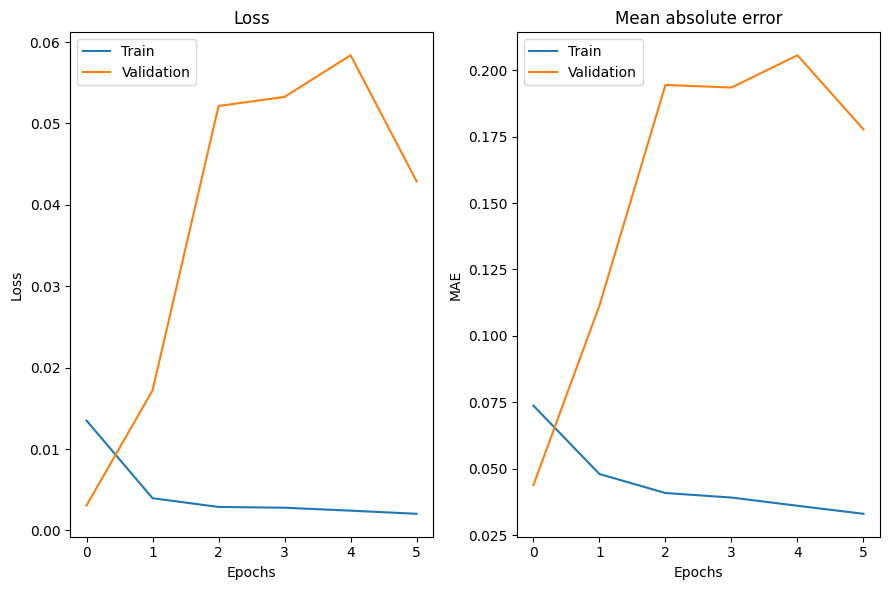

In [12]:
plot_history(ss_dnn_history)

### Add a learning rate scheduler 

In [19]:
# Add a learning rate scheduler
from tensorflow.keras.callbacks import LearningRateScheduler



In [27]:
def scheduler(epoch, lr):

    if epoch < 2:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))
    
lr_scheduler = LearningRateScheduler(scheduler)

def train_model(model, train_ds, val_ds, patience=5, max_epochs=50, use_scheduler=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    if use_scheduler == True:
        # Add the scheduler as a callback
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])
    
    return history

In [28]:
scheduler(3, 0.001)

0.0009048374486155808

In [29]:
ss_dnn_history = train_model(ss_dnn, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.8959e-04 - mean_absolute_error: 0.0173 - val_loss: 2.8150e-04 - val_mean_absolute_error: 0.0130
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8912e-04 - mean_absolute_error: 0.0172 - val_loss: 2.3838e-04 - val_mean_absolute_error: 0.0117
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.9381e-04 - mean_absolute_error: 0.0174 - val_loss: 2.2724e-04 - val_mean_absolute_error: 0.0114
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8634e-04 - mean_absolute_error: 0.0172 - val_loss: 2.2686e-04 - val_mean_absolute_error: 0.0116
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8293e-04 - mean_absolute_error: 0.0172 - val_loss: 2.3577e-04 - val_mean_absolute_error: 0.0118
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8294e-04 - mean_absolute_error: 0.0172 - val_loss: 2.4440e-04 - val_mean_absolute_error: 0.0121
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 

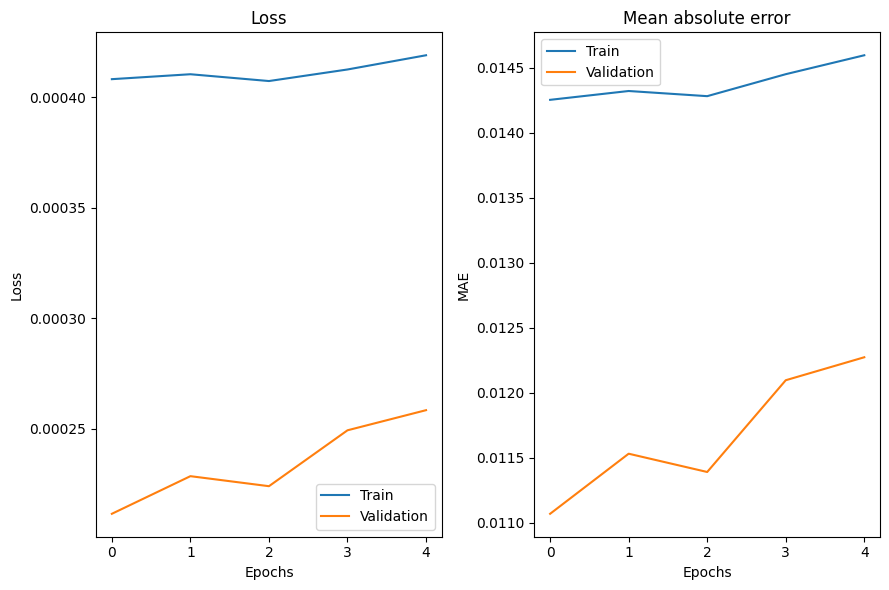

In [30]:
plot_history(ss_dnn_history)

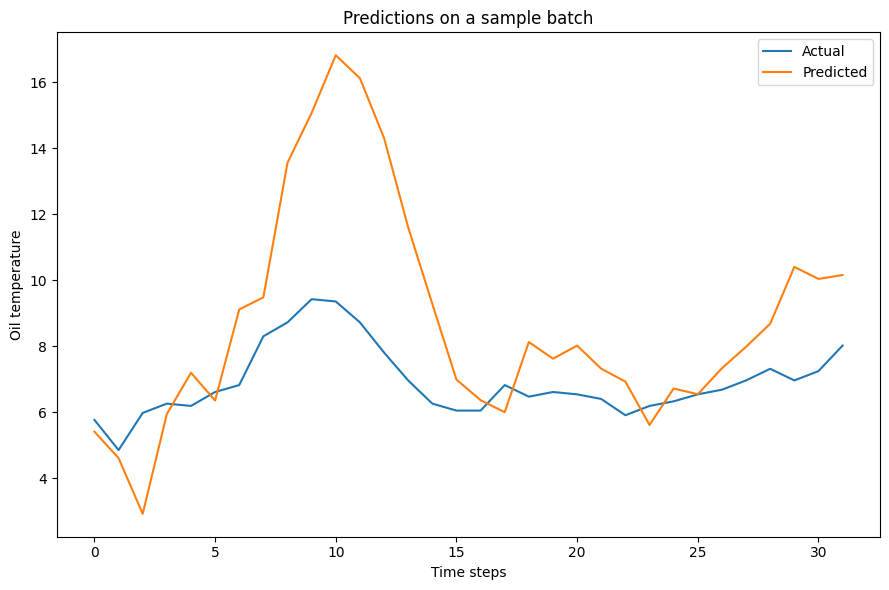

In [31]:
plot_predictions(ss_dnn, ss_sample_batch, 'single_step')

### Evaluation 

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - mean_absolute_error: 0.0473


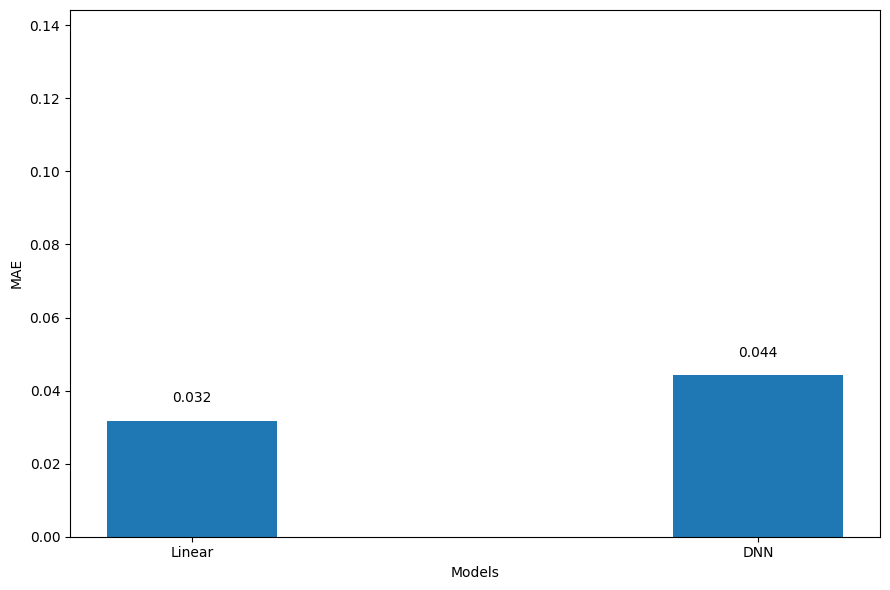

In [32]:
ss_mae = [0.0318]
ss_mae.append(ss_dnn.evaluate(test_ds_ss)[1])

x = ['Linear', 'DNN']

fig, ax = plt.subplots()
ax.bar(x, ss_mae, width=0.3)
ax.set_ylabel('MAE')
ax.set_xlabel('Models')
ax.set_ylim(0, max(ss_mae)+0.1)
for index, value in enumerate(ss_mae):
    ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
plt.tight_layout()

## Multi-step model 

In [33]:
train_ds_ms = format_timeseries_data(train_df, 24, 24, ['OT'])
val_ds_ms = format_timeseries_data(val_df, 24, 24, ['OT'])
test_ds_ms = format_timeseries_data(test_df, 24, 24, ['OT'])

ms_sample_batch = next(iter(test_ds_ms))

In [34]:
# Create a multi-step DNN model
ms_dnn = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ms_dnn_history = train_model(ms_dnn, train_ds_ms, val_ds_ms)

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089 - mean_absolute_error: 0.0709 - val_loss: 0.0063 - val_mean_absolute_error: 0.0650
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0086 - mean_absolute_error: 0.0704 - val_loss: 0.0032 - val_mean_absolute_error: 0.0431
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0589 - val_loss: 0.0053 - val_mean_absolute_error: 0.0567
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0590 - val_loss: 0.0084 - val_mean_absolute_error: 0.0709
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082 - mean_absolute_error: 0.0655 - val_loss: 0.0069 - val_mean_absolute_error: 0.0638
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0649 - val_loss: 0.0049 - val_mean_absolute_error: 0.0541
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0642 - v

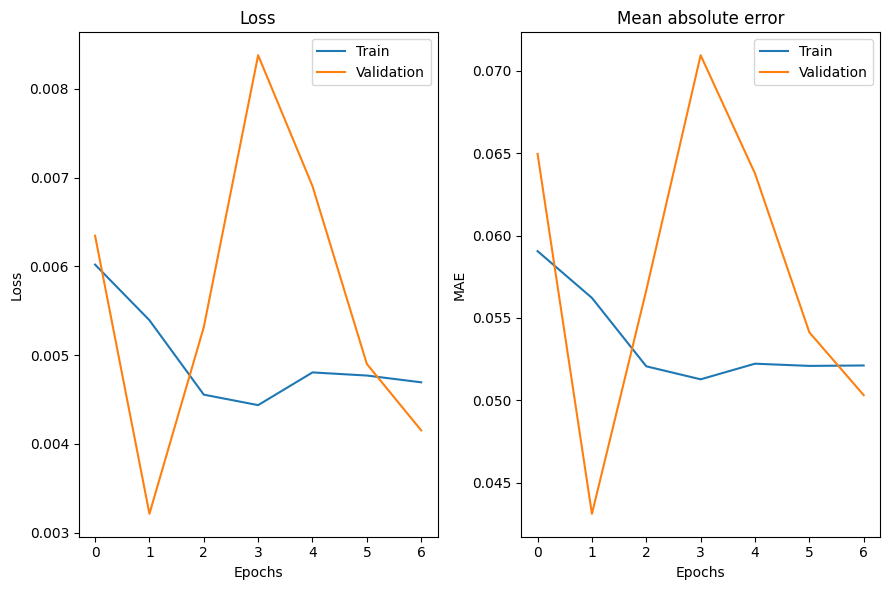

In [35]:
plot_history(ms_dnn_history)

In [36]:
ms_dnn_history = train_model(ms_dnn, train_ds_ms, val_ds_ms, use_scheduler=True)

Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0063 - mean_absolute_error: 0.0611 - val_loss: 0.0034 - val_mean_absolute_error: 0.0466
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0625 - val_loss: 0.0030 - val_mean_absolute_error: 0.0427
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - mean_absolute_error: 0.0593 - val_loss: 0.0032 - val_mean_absolute_error: 0.0437
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0621 - val_loss: 0.0035 - val_mean_absolute_error: 0.0456
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0073 - mean_absolute_error: 0.0646 - val_loss: 0.0039 - val_mean_absolute_error: 0.0511
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0650 - val_loss: 0.0043 - val_mean_absolute_error: 0.0542
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0644 - v

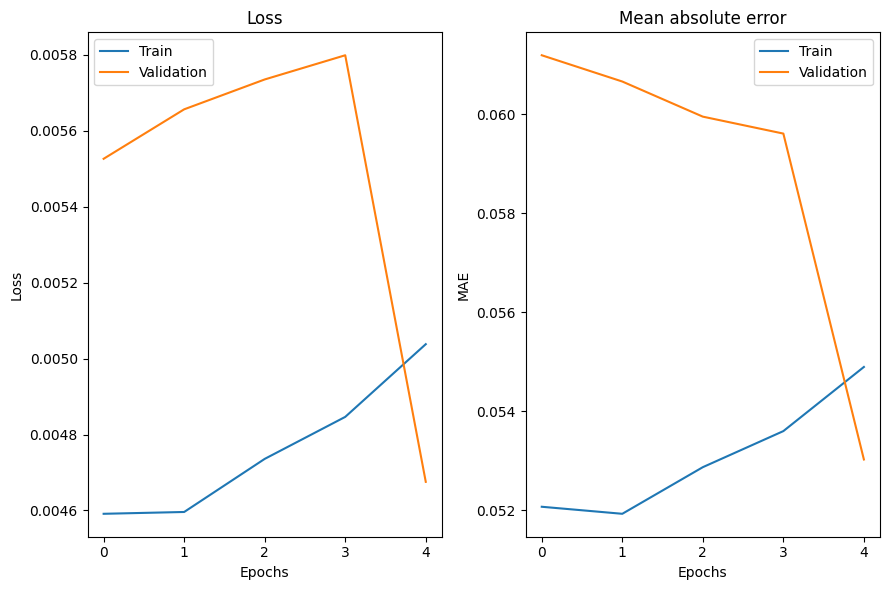

In [37]:
plot_history(ms_dnn_history)

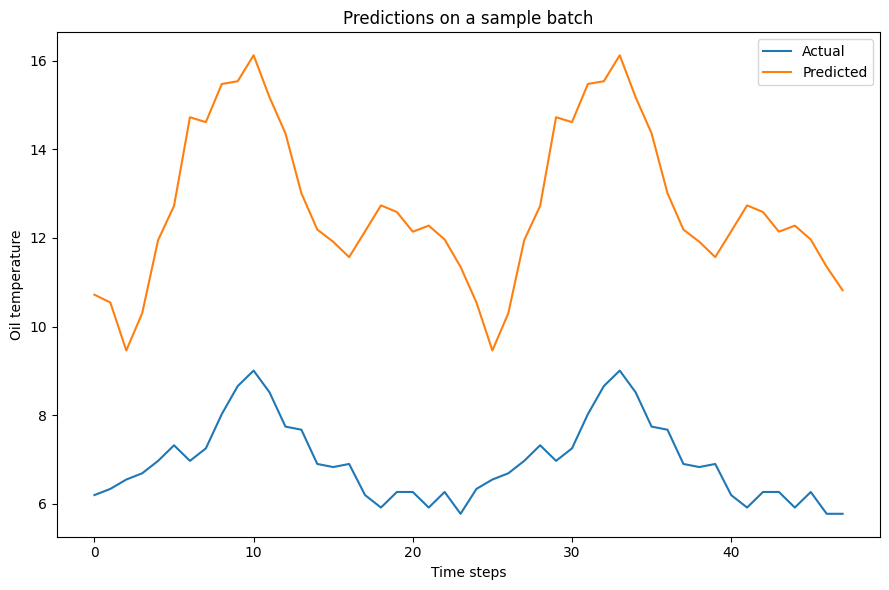

In [38]:
plot_predictions(ms_dnn, ms_sample_batch, 'multi_step')

### Evaluation 

 1/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0083 - mean_absolute_error: 0.0750

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0415 - mean_absolute_error: 0.1639


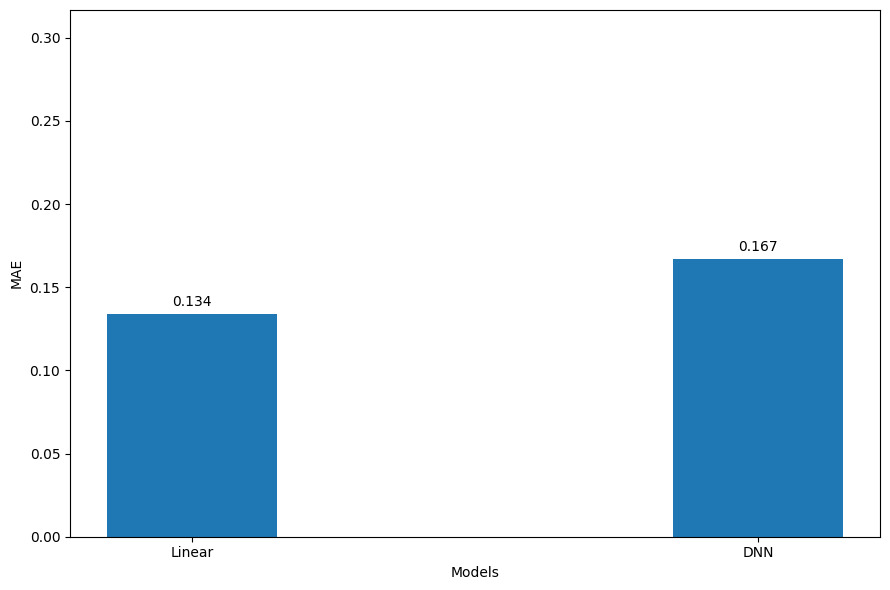

In [40]:
ms_mae = [0.1338]
ms_mae.append(ms_dnn.evaluate(test_ds_ms)[1])

x = ['Linear', 'DNN']

fig, ax = plt.subplots()
ax.bar(x, ms_mae, width=0.3)
ax.set_ylabel('MAE')
ax.set_xlabel('Models')
ax.set_ylim(0, max(ms_mae)+0.15)
for index, value in enumerate(ms_mae):
    ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
plt.tight_layout()

## Multi-output model 

In [41]:
train_ds_mo = format_timeseries_data(train_df, 1, 1, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, 1, 1, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, 1, 1, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [43]:
# Create a multi-output DNN
mo_dnn = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

mo_dnn_history = train_model(mo_dnn, train_ds_mo, val_ds_mo)

Epoch 1/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0803 - mean_absolute_error: 0.1781 - val_loss: 0.0510 - val_mean_absolute_error: 0.1923
Epoch 2/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0157 - mean_absolute_error: 0.0973 - val_loss: 0.0387 - val_mean_absolute_error: 0.1821
Epoch 3/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - mean_absolute_error: 0.0855 - val_loss: 0.0395 - val_mean_absolute_error: 0.1822
Epoch 4/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - mean_absolute_error: 0.0800 - val_loss: 0.0389 - val_mean_absolute_error: 0.1823
Epoch 5/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0816 - val_loss: 0.0388 - val_mean_absolute_error: 0.1823
Epoch 6/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0104 - mean_absolute_error: 0.0798 - val_loss: 0.0394 - val_mean_absolute_error: 0.1830
Epoch 7/50
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0103 - mean_absolute_error: 0.0790 - v

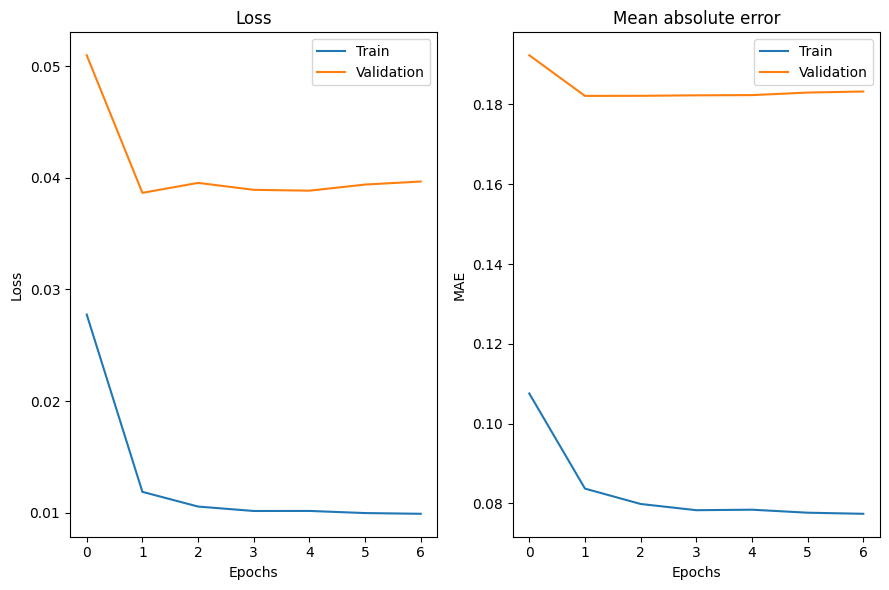

In [44]:
plot_history(mo_dnn_history)

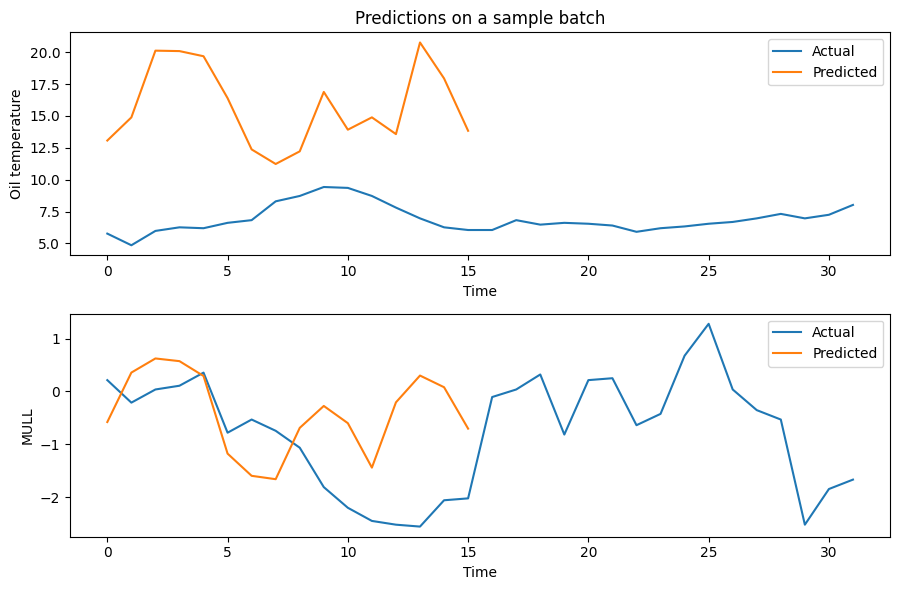

In [45]:
plot_predictions(mo_dnn, mo_sample_batch, 'multi_output')

### Evaluation 

In [47]:
def plot_evaluation(model_list, mae):
    
    fig, ax = plt.subplots()
    
    ax.bar(model_list, mae, width=0.3)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Models')
    ax.set_ylim(0, max(mae)+0.15)
    for index, value in enumerate(mae):
        ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
    
    plt.tight_layout()

 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0232 - mean_absolute_error: 0.1307

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0241 - mean_absolute_error: 0.1262


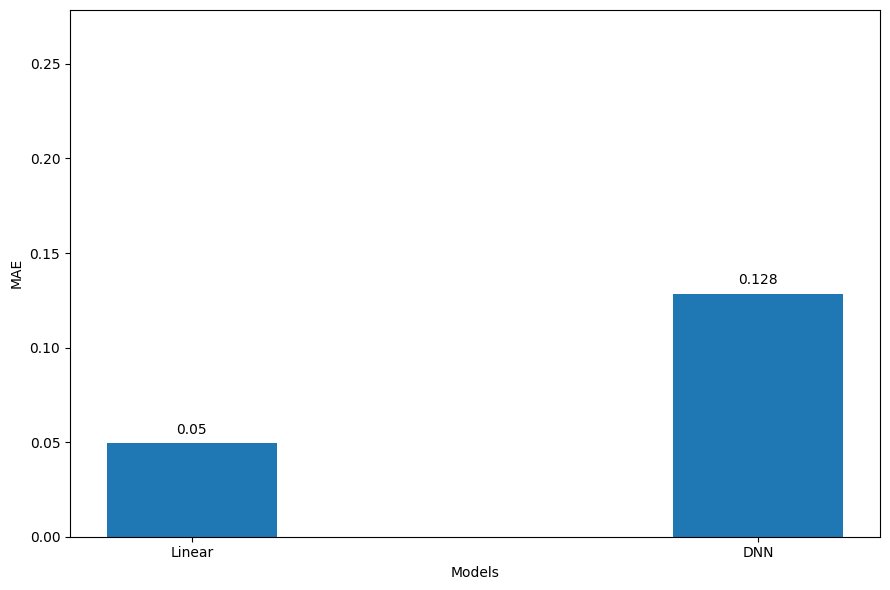

In [48]:
model_list = ['Linear', 'DNN']

mo_mae = [0.0495]
mo_mae.append(mo_dnn.evaluate(test_ds_mo)[1])

plot_evaluation(model_list, mo_mae)